In [1]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import TweedieRegressor
from sklearn.linear_model import LassoLars

from scipy import stats
from scipy.stats import pearsonr, spearmanr

from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import SelectKBest, f_regression, RFE

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import TweedieRegressor
from sklearn.linear_model import LassoLars
from sklearn.cluster import KMeans


# import my functions
import prepare

# turn off pink warning boxes
import warnings
warnings.filterwarnings("ignore")

In [2]:
red = pd.read_csv('winequality-red.csv')
white = pd.read_csv('winequality-white.csv')

In [3]:
# creating a list for new column
color = 'red'

red.insert(0, 'color', color)
red.head()

,color,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,red,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,red,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,red,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,red,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,red,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
color = 'white'

white.insert(0, 'color', color)
white.head()

,color,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


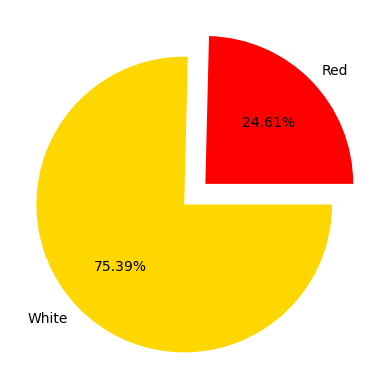

In [5]:
#plotting amount of red and white wines overall
values = [red.shape[0], white.shape[0]]
labels = ('Red', 'White')
plt.pie(values, labels = labels, autopct = "%.2f%%", explode = (0.1, 0.1), colors = ('red', 'gold'))
plt.show()

In [6]:
red.quality.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [7]:
white.quality.value_counts()

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64

In [8]:
wine = pd.concat([white, red], ignore_index=True)
wine.head()


#df = pd.concat([df, dummies], axis = 1)

,color,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [9]:
wine.head()

,color,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [10]:
wine.shape

(6497, 13)

In [11]:
wine.rename(columns = {'fixed acidity' : 'fixed_acidity', 'volatile acidity' : 'volatile_acidity', 
                       'citric acid' : 'citric_acid', 'residual sugar': 'rs', 'free sulfur dioxide': 'free_s02',
                       'total sulfur dioxide' : 'total_s02'}, inplace = True)

In [12]:
wine.head(1)

,color,fixed_acidity,volatile_acidity,citric_acid,rs,chlorides,free_s02,total_s02,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.001,3.0,0.45,8.8,6


In [13]:
wine['quality'].head()

0    6
1    6
2    6
3    6
4    6
Name: quality, dtype: int64

<AxesSubplot:ylabel='total_s02'>

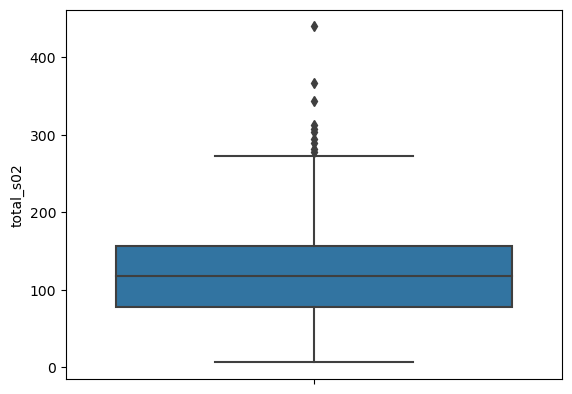

In [14]:
sns.boxplot(data=wine, y = 'total_s02')


In [15]:
def remove_outliers(df, k=2):
    '''
    This function is to remove the top 25% and bottom 25% of the data for each column.
    This removes the top and bottom 50% for every column to ensure all outliers are gone.
    '''
    a=[]
    b=[]
    fences=[a, b]
    features= []
    col_list = []
    i=0
    for col in df:
            new_df=np.where(df[col].nunique()>8, True, False)
            if new_df==True:
                if df[col].dtype == 'float' or df[col].dtype == 'int':
                    '''
                    for each feature find the first and third quartile
                    '''
                    q1, q3 = df[col].quantile([.25, .75])
                    '''
                    calculate inter quartile range
                    '''
                    iqr = q3 - q1
                    '''
                    calculate the upper and lower fence
                    '''
                    upper_fence = q3 + (k * iqr)
                    lower_fence = q1 - (k * iqr)
                    '''
                    appending the upper and lower fences to lists
                    '''
                    a.append(upper_fence)
                    b.append(lower_fence)
                    '''
                    appending the feature names to a list
                    '''
                    features.append(col)
                    '''
                    assigning the fences and feature names to a dataframe
                    '''
                    var_fences= pd.DataFrame(fences, columns=features, index=['upper_fence', 'lower_fence'])
                    col_list.append(col)
                else:
                    print(col)
                    print('column is not a float or int')
            else:
                print(f'{col} column ignored')
    '''
    for loop used to remove the data deemed unecessary
    '''
    for col in col_list:
        df = df[(df[col]<= a[i]) & (df[col]>= b[i])]
        i+=1
    return df, var_fences
     

In [16]:
wine, var_fences = remove_outliers(wine)

color column ignored
quality column ignored


In [17]:
wine.head()

,color,fixed_acidity,volatile_acidity,citric_acid,rs,chlorides,free_s02,total_s02,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [18]:
wine.shape

(5757, 13)

In [19]:
wine.quality.value_counts()

6    2533
5    1851
7    1004
8     179
4     172
3      13
9       5
Name: quality, dtype: int64

In [20]:
wine.describe()
    

,fixed_acidity,volatile_acidity,citric_acid,rs,chlorides,free_s02,total_s02,density,pH,sulphates,alcohol,quality
count,5757.000000,5757.000000,5757.000000,5757.000000,5757.000000,5757.000000,5757.000000,5757.000000,5757.000000,5757.000000,5757.000000,5757.000000
mean,7.034176,0.319750,0.307355,5.591906,0.050010,31.125413,119.781136,0.994420,3.218933,0.514530,10.519964,5.851138
std,0.974296,0.137262,0.122002,4.715453,0.018637,16.437084,53.638754,0.002858,0.155408,0.123028,1.200953,0.863658
min,3.900000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.220000,0.250000,1.800000,0.037000,18.000000,87.000000,0.992050,3.110000,0.420000,9.500000,5.000000
50%,6.900000,0.280000,0.310000,3.400000,0.046000,29.000000,121.000000,0.994560,3.210000,0.500000,10.400000,6.000000
75%,7.500000,0.380000,0.380000,8.400000,0.057000,42.000000,157.000000,0.996660,3.320000,0.590000,11.400000,6.000000
max,10.300000,0.740000,0.670000,20.700000,0.119000,89.000000,303.000000,1.002600,3.720000,0.940000,14.200000,9.000000


In [21]:
#Removing the very few super high quality wines and very few super low quality wines
wine = wine[wine.quality != 9]
wine = wine[wine.quality != 3]

In [22]:
#After removing the high and low qualities we only removed 18 lines(13 low, 5 high) from the dataset
wine.shape

(5739, 13)

# Our wine quality categories now range from 4 to 8

In [23]:
wine.quality.value_counts()

6    2533
5    1851
7    1004
8     179
4     172
Name: quality, dtype: int64

In [24]:
train, val, test = prepare.train_val_test(wine)
train.shape, val.shape, test.shape

((4017, 13), (1033, 13), (689, 13))

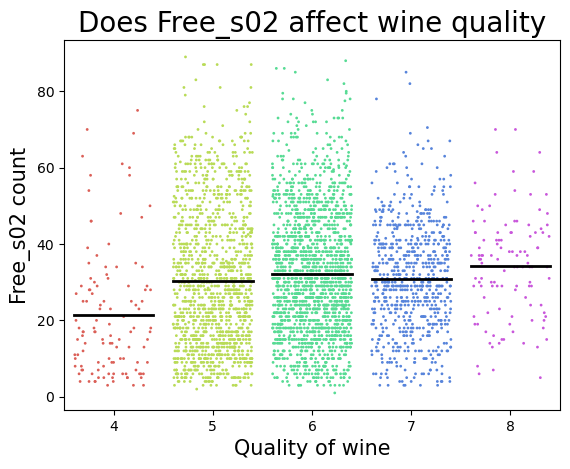

In [25]:
# Creating a visual displaying amount distro comapred to mean
p = sns.stripplot(y =train.free_s02, x = train.quality, data = train, size = 2, jitter = .4, palette = 'hls')
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="quality",
            y="free_s02",
            data=train,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)
plt.ylabel('Free_s02 count', fontdict = { 'fontsize': 15})
plt.xlabel('Quality of wine', fontdict = { 'fontsize': 15})
plt.title('Does Free_s02 affect wine quality', fontdict = { 'fontsize': 20})
plt.show()

Free S02 doesn't seem to have an affect


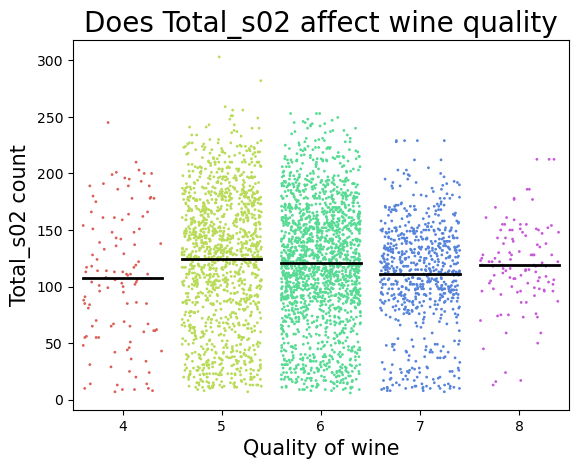

In [26]:
# Creating a visual displaying amount distro comapred to mean
p = sns.stripplot(y =train.total_s02, x = train.quality, data = train, size = 2, jitter = .4, palette = 'hls')
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="quality",
            y="total_s02",
            data=train,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)
plt.ylabel('Total_s02 count', fontdict = { 'fontsize': 15})
plt.xlabel('Quality of wine', fontdict = { 'fontsize': 15})
plt.title('Does Total_s02 affect wine quality', fontdict = { 'fontsize': 20})
plt.show()

Total s02 doesn't seem to have an affect on quality


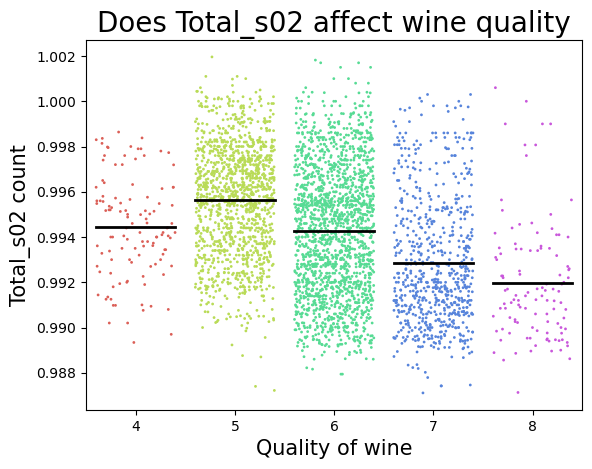

In [27]:
# Creating a visual displaying amount distro comapred to mean
p = sns.stripplot(y =train.density, x = train.quality, data = train, size = 2, jitter = .4, palette = 'hls')
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="quality",
            y="density",
            data=train,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)
plt.ylabel('Total_s02 count', fontdict = { 'fontsize': 15})
plt.xlabel('Quality of wine', fontdict = { 'fontsize': 15})
plt.title('Does Total_s02 affect wine quality', fontdict = { 'fontsize': 20})
plt.show()

<AxesSubplot:>

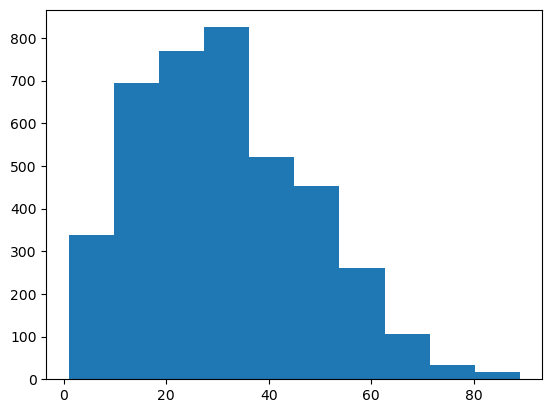

In [28]:
train.free_s02.hist(grid = False)

### 1.
* H_0 : There is no relationship between total sulphur dioxide level in wine and its overall quality.
* H_a : There is a relationship between total sulphur dioxide level in wine and its overall quality.

### 2.
- H_0 : The levels of citric acid and residual sugar in the wine have no relationship to its quality.
- H_a : The levels of citric acid and residual sugar in the wine have a relationship to its quality.

In [29]:
# Scaling the data
scaler, train_scaled, val_scaled, test_scaled = prepare.scale_splits_rb(train, 
                                                                        val, 
                                                                        test, 
                                                                        return_scaler = True)    

In [35]:
train_scaled.head()

,color,fixed_acidity,volatile_acidity,citric_acid,rs,chlorides,free_s02,total_s02,density,pH,sulphates,alcohol,quality,cluster
496,white,0.515625,0.484848,0.925373,0.505,0.290909,0.784091,0.616162,0.706397,0.346939,0.366197,0.096774,4,1
4870,white,0.343750,0.363636,0.417910,0.295,0.109091,0.318182,0.424242,0.321212,0.418367,0.183099,0.556452,7,0
4531,white,0.531250,0.303030,0.805970,0.610,0.363636,0.693182,0.526936,0.760269,0.326531,0.309859,0.177419,6,1
4350,white,0.484375,0.424242,0.373134,0.250,0.054545,0.147727,0.225589,0.169697,0.081633,0.507042,0.838710,6,0
1749,white,0.343750,0.136364,0.402985,0.040,0.427273,0.500000,0.434343,0.356229,0.469388,0.281690,0.354839,6,2


In [36]:
train.head()

,color,fixed_acidity,volatile_acidity,citric_acid,rs,chlorides,free_s02,total_s02,density,pH,sulphates,alcohol,quality
496,white,7.2,0.40,0.62,10.8,0.041,70.0,189.0,0.99760,3.08,0.49,8.60,4
4870,white,6.1,0.32,0.28,6.6,0.021,29.0,132.0,0.99188,3.15,0.36,11.45,7
4531,white,7.3,0.28,0.54,12.9,0.049,62.0,162.5,0.99840,3.06,0.45,9.10,6
4350,white,7.0,0.36,0.25,5.7,0.015,14.0,73.0,0.98963,2.82,0.59,13.20,6
1749,white,6.1,0.17,0.27,1.5,0.056,45.0,135.0,0.99240,3.20,0.43,10.20,6


In [ ]:
# creating dummy column for colour
dummies = pd.get_dummies(wine[[‘color’]], drop_first = True)
# concatenating dummies to the wine dataframe
wine = pd.concat([wine, dummies], axis = 1)

In [30]:
rs_alc_train = train_scaled[['rs', 'alcohol']]

In [31]:
kmeans = KMeans(n_clusters= 3)

kmeans.fit(rs_alc_train)

kmeans.predict(rs_alc_train)

array([1, 0, 1, ..., 0, 2, 2], dtype=int32)

In [32]:
train_scaled['cluster'] = kmeans.predict(rs_alc_train)

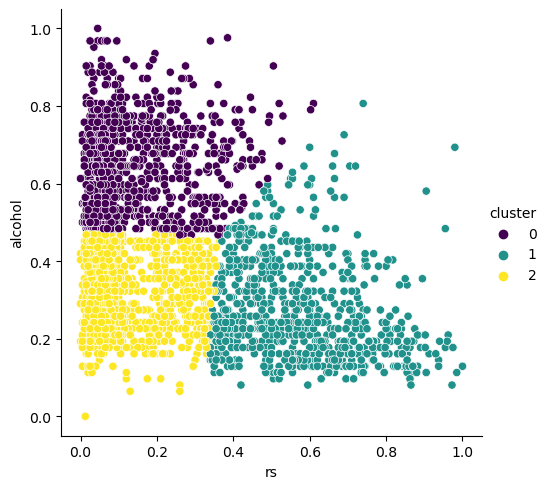

In [33]:
sns.relplot(x = 'rs', y = 'alcohol', hue='cluster', palette='viridis', data=train_scaled)
plt.show()

### 3.
* H_0 : The level of volatile acidity in the wine has no relationship to its quality.
* H_a : The level of volatile acidity in the wine has a relationship to its quality.

### 4.
* H_0 : The total alcohol level of the wine has no relationship to its quality.
* you H_a : The total alcohol level of the wine has a relationship to its quality.
